In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings

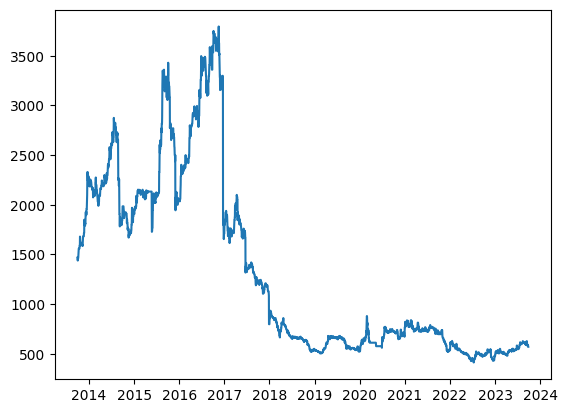

In [4]:
# Read the data and preprocess it
df = pd.read_excel('C:\\Users\\User\\Desktop\\project\\EBL_data.xlsx')
df.set_index('Date', inplace=True)
df = df.dropna(subset=['Close'])
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df['Close'] = df['Close'].ffill()

# Visualize the data
plt.plot(df.index, df['Close'])
plt.show()

In [5]:
# Perform ADF test for checking stationarity
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. No.of Lags : ", dftest[2])
    print("4. No.of Observations used for ADF Regression and Critical Values Calculation:", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

ad_test(df['Close'])

1. ADF :  -1.2992087335569515
2. P-Value :  0.6295342412445168
3. No.of Lags :  10
4. No.of Observations used for ADF Regression and Critical Values Calculation: 3640
5. Critical Values : 
	 1% : -3.4321477795421935
	 5% : -2.8623343588485692
	 10% : -2.5671928493690377


In [6]:
# Make the data stationary by differencing
df['Close_diff'] = df['Close'] - df['Close'].shift(1)
df = df.dropna() 

In [7]:
# Use auto_arima to determine the ARIMA model order
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(df['Close_diff'], trace=True, suppress_warnings=True)
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=23872.483, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23899.149, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23874.311, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=23876.595, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23897.320, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=23873.890, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=23874.353, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=23873.467, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=23873.543, Time=0.73 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23874.026, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=23875.277, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=23874.805, Time=0.64 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=23874.839, Time=1.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23870.621, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2281
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -11930.311
Date:                Thu, 05 Oct 2023   AIC                          23870.621
Time:                        22:24:17   BIC                          23899.283
Sample:                             0   HQIC                         23881.075
                               - 2281                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5207      0.244      2.137      0.033       0.043       0.998
ar.L2         -0.4481      0.131     -3.415      0.001      -0.705      -0.191
ma.L1         -0.4198      0.244     -1.720      0.085      -0.898       0.059
ma.L2          0.4542      0.111      4.077      0.000       0.236       0.673
sigma2      2047.0400      7.316    279.805      0.000    2032.701    2061.379
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):          14461793.71
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                           -13.33
Prob(H) (two-sided):                  0.00   Kurtosis:                       392.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# Split the data
to_row = int(len(df) * 0.9)
training_data = list(df[0:to_row]['Close'])
testing_data = list(df[to_row:]['Close'])
print(len(testing_data))

229


In [9]:
# Define the number of test observations
n_test_obser = len(testing_data)


model_prediction = [] 
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(training_data, order=(2, 0, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_prediction.append(yhat)  # Append the prediction for each day
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)
    print(f"Day {i}: Forecasted = {yhat:.1f}, Actual = {actual_test_value}")


Day 0: Forecasted = 480.3, Actual = 481.0
Day 1: Forecasted = 482.7, Actual = 476.0
Day 2: Forecasted = 476.9, Actual = 479.9
Day 3: Forecasted = 481.4, Actual = 495.8
Day 4: Forecasted = 499.0, Actual = 490.0
Day 5: Forecasted = 491.4, Actual = 483.0
Day 6: Forecasted = 483.2, Actual = 484.0
Day 7: Forecasted = 485.2, Actual = 485.0
Day 8: Forecasted = 486.6, Actual = 510.0
Day 9: Forecasted = 514.0, Actual = 504.0
Day 10: Forecasted = 505.8, Actual = 495.5
Day 11: Forecasted = 495.4, Actual = 493.0
Day 12: Forecasted = 493.7, Actual = 504.9
Day 13: Forecasted = 507.5, Actual = 533.0
Day 14: Forecasted = 537.8, Actual = 545.2
Day 15: Forecasted = 548.9, Actual = 545.0
Day 16: Forecasted = 546.5, Actual = 532.0
Day 17: Forecasted = 531.8, Actual = 540.0
Day 18: Forecasted = 541.5, Actual = 531.0
Day 19: Forecasted = 531.8, Actual = 530.2
Day 20: Forecasted = 530.9, Actual = 525.0
Day 21: Forecasted = 525.8, Actual = 522.9
Day 22: Forecasted = 523.8, Actual = 514.0
Day 23: Forecasted = 

In [10]:
print(f'Predicted value is{yhat:.1f}')

Predicted value is580.6


In [11]:
date_range = df.index[to_row:to_row + n_test_obser]
print(len(date_range))

229


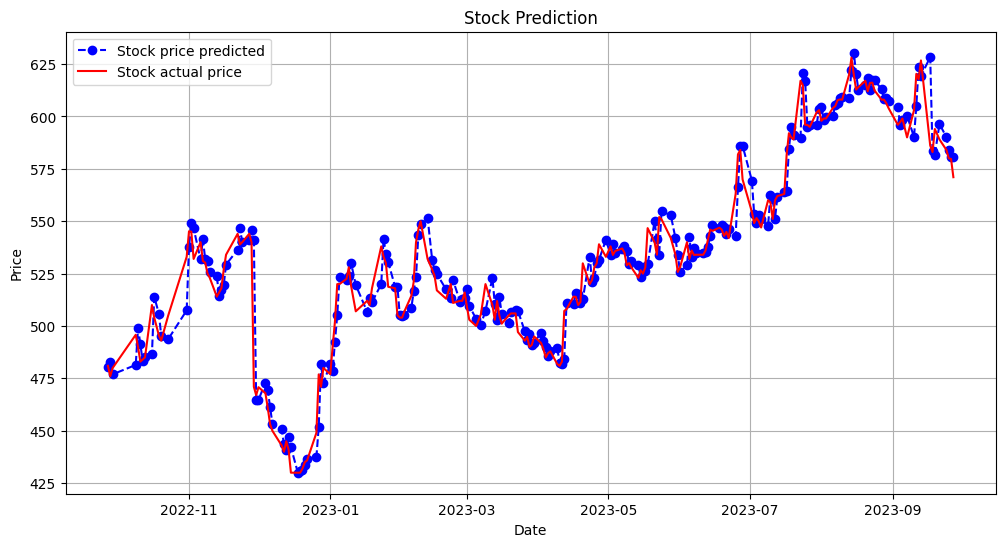

In [12]:


# Plot the data
plt.figure(figsize=(12, 6))
plt.grid(True)

plt.plot(date_range, model_prediction, color='blue', marker='o', linestyle='dashed', label='Stock price predicted')
plt.plot(date_range, testing_data[:n_test_obser], color='red', label='Stock actual price')  # Slice testing_data to match the length
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
#Calculate the errors 
mape=np.mean(np.abs(np.array(model_prediction)-np.array(testing_data))/np.abs(testing_data))
print('MAPE: '+str(mape))
mae = mean_absolute_error(testing_data, model_prediction)
print('MAE: '+str(mae))

MAPE: 0.012410066388058319
MAE: 6.569399859344534
